# MD2NMR - Gaussian Mixture Modeling

In [1]:
import sys, os, re, glob, multiprocessing, argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/home/dkoes/git/MD2NMR/")
import shiftres,shifts

In [2]:
db = shiftres.read_db('../nmr.db')

In [3]:
parser = argparse.ArgumentParser()
shiftres.add_shift_args(parser)
sys.argv = ['python']
args = parser.parse_args()
args.verbose = False

Investigate fitting shifts to gaussian mixture model.  

* 1L2Y TRP6

In [4]:
allres = []
for fname in glob.glob('benchmark/1l2y/ff14SB/1l2y_*_dump/TRP.N.6.gz'):
    res = shifts.shifts_from_file(db,fname,6,'TRP',args)
    allres.append(res[4][:,1:4])
resshifts = np.vstack(allres)

In [5]:
len(resshifts)

599999

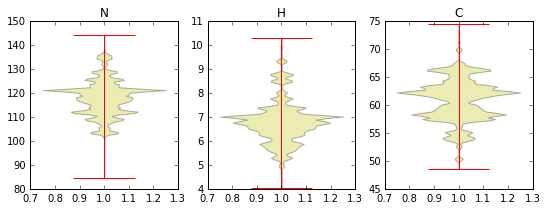

In [6]:
f, (N,H,C) = plt.subplots(1,3,figsize=(9,3))
N.violinplot(resshifts[:,0]);
N.set_title('N')
H.violinplot(resshifts[:,1]);
H.set_title('H')
C.violinplot(resshifts[:,2]);
C.set_title('C')

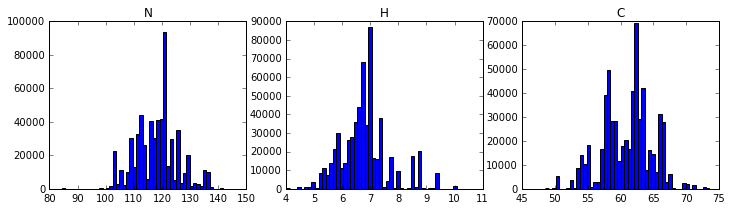

In [147]:
fresshifts, (N,H,C) = plt.subplots(1,3,figsize=(12,3))
N.hist(resshifts[:,0],bins=50);
N.set_title('N')
H.hist(resshifts[:,1],bins=50);
H.set_title('H')
C.hist(resshifts[:,2],bins=50);
C.set_title('C');

In [23]:
from scipy import linalg
from sklearn import mixture
import multiprocessing

In [43]:
def calc_bics(a):
    (resshifts,num,rand) = a
    '''Calculate Baysian information criteria for different sized mixtures.  This will change depending on the initialization used.'''
    bics = []
    for i in xrange(1,num+1):
        gmm = mixture.GaussianMixture(n_components=i,random_state=rand)
        gmm.fit(resshifts)
        bic = gmm.bic(resshifts)
        bics.append(bic)
    return bics        

In [46]:
pool = multiprocessing.Pool(8)
allbics = pool.map(calc_bics,[(resshifts,12,rand) for rand in xrange(8)])

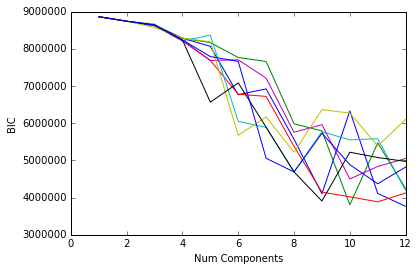

In [52]:
for bics in allbics:
    plt.plot(xrange(1,len(bics)+1),bics)
plt.ylabel("BIC")
plt.xlabel("Num Components");

Although there appears to be a minimum at 7-9, adding more components drives the BIC even lower and by a substantial amount (see below), suggesting the data is not well represented by a small number of Gaussians.  Also, the high variability depending on the initial seeds used raises doubts about the robustness of this approach for identifying a definitive number of states.

In [11]:
gmm = mixture.GaussianMixture(n_components=50)
gmm.fit(resshifts)
bic = gmm.bic(resshifts)
bic

-4902802.6127876379

In [20]:
gmm7 = mixture.GaussianMixture(n_components=7,n_init=10)
gmm7.fit(resshifts)
bic = gmm7.bic(resshifts)
bic

4956040.1303935768

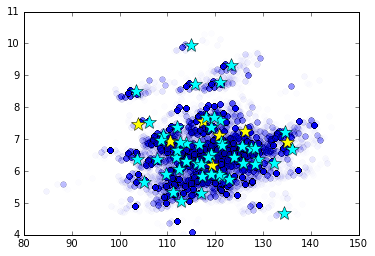

In [16]:
plt.plot(resshifts[:,0],resshifts[:,1],'o',alpha=.01,lw=0)
plt.plot(gmm7.means_[:,0],gmm7.means_[:,1],'*',markersize=15,color='yellow')
plt.plot(gmm.means_[:,0],gmm.means_[:,1],'*',markersize=15,color='cyan')

What happens if we look at a more stable residue and a single simulation?
* VAL26 1UBQ - part of helix, side chain buried 

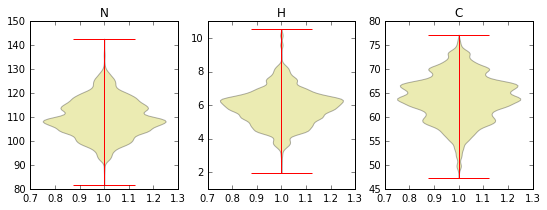

In [34]:
valshifts = shifts.shifts_from_file(db,'benchmark/1ubq/ff14SB/1ubq_0_dump/VAL.N.26.gz',26,'VAL',args)[4][:,1:4]
f, (N,H,C) = plt.subplots(1,3,figsize=(9,3))
N.violinplot(valshifts[:,0]);
N.set_title('N')
H.violinplot(valshifts[:,1]);
H.set_title('H')
C.violinplot(valshifts[:,2]);
C.set_title('C')

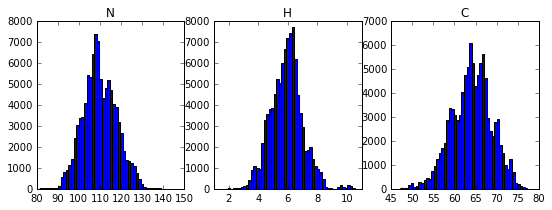

In [59]:
f, (N,H,C) = plt.subplots(1,3,figsize=(9,3))
N.hist(valshifts[:,0],bins=50);
N.set_title('N')
H.hist(valshifts[:,1],bins=50);
H.set_title('H')
C.hist(valshifts[:,2],bins=50);
C.set_title('C');

In [57]:
valbics = pool.map(calc_bics,[(valshifts,50,rand) for rand in xrange(8)])

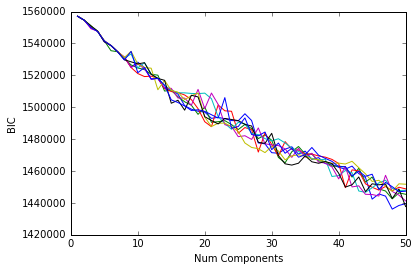

In [58]:
for bics in valbics:
    plt.plot(xrange(1,len(bics)+1),bics)
plt.ylabel("BIC")
plt.xlabel("Num Components");

Even with a more well behaved distribution, the preference is to fit with a large number of Gaussians.  Let's plot the 1-D projections of these multi-dimensional Guassians..

In [60]:
gmm9 = mixture.GaussianMixture(n_components=9,n_init=10)
gmm9.fit(valshifts)
bic = gmm9.bic(valshifts)
bic

1524846.1325912287

In [61]:
gmm3 = mixture.GaussianMixture(n_components=3,n_init=10)
gmm3.fit(valshifts)
bic = gmm3.bic(valshifts)
bic

1549252.4012799815

In [103]:
import matplotlib.mlab as mlab
def plot_gmm(G):
    f, ax = plt.subplots(1,3,figsize=(12,3))
    titles = ['N','H','C']
    for i in xrange(3):
        ax[i].hist(valshifts[:,i],bins=50,normed=True)
        ax[i].set_title(titles[i])
        x = np.linspace(valshifts[:,i].min(),valshifts[:,i].max(),50)
        for m in xrange(len(G.means_)):
            ax[i].plot(x,mlab.normpdf(x,G.means_[m][i],np.sqrt(G.covariances_[m][i][i])))
    return f

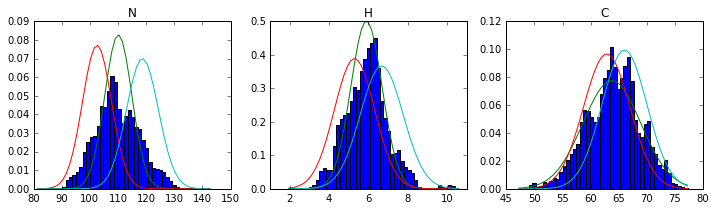

In [104]:
plot_gmm(gmm3);

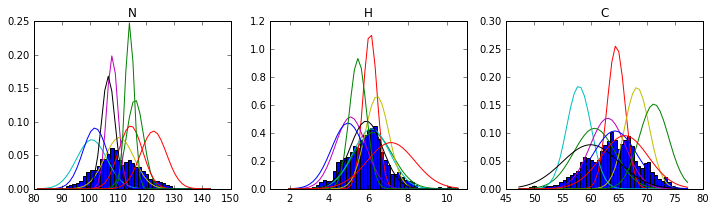

In [105]:
plot_gmm(gmm9);

Sanity chek with a single dimension data.

In [108]:
g3 = mixture.GaussianMixture(n_components=3,n_init=10)
g3.fit(valshifts[:,0].reshape(-1,1))
g3.bic(valshifts[:,0].reshape(-1,1))

696664.68184935313

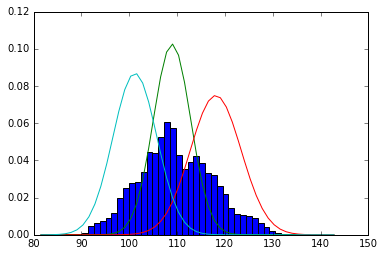

In [109]:
N = valshifts[:,0]
plt.hist(N,bins=50,normed=True)
x = np.linspace(N.min(),N.max(),50)
for m in xrange(len(g3.means_)):
    plt.plot(x,mlab.normpdf(x,g3.means_[m],np.sqrt(g3.covariances_[m][0][0])))

This isn't working very well.  Try the alternative variational method.

In [111]:
bgm = mixture.BayesianGaussianMixture(n_components=25,max_iter=1000)
bgm.fit(valshifts)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=25, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [116]:
len(set(bgm.predict(valshifts))) # number of components

25

The default settings still generate the max number of Gaussians.  Try decreasing the prior.

In [117]:
bgm = mixture.BayesianGaussianMixture(n_components=25,max_iter=1000,weight_concentration_prior=0.00001)
bgm.fit(valshifts)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=1000, mean_precision_prior=None, mean_prior=None,
            n_components=25, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=1e-05,
            weight_concentration_prior_type='dirichlet_process')

In [118]:
len(set(bgm.predict(valshifts))) # number of components

25

Still uses the max allowed number of components.  Let's check the distribution of assignments of inputs to components.

In [120]:
import collections

In [138]:
cnts = collections.Counter(bgm.predict(valshifts))
cnts

Counter({0: 2933,
         1: 7251,
         2: 2178,
         3: 1550,
         4: 5725,
         5: 721,
         6: 3279,
         7: 3121,
         8: 1470,
         9: 1957,
         10: 20440,
         11: 5903,
         12: 3176,
         13: 2704,
         14: 5550,
         15: 794,
         16: 665,
         17: 5192,
         18: 2850,
         19: 1407,
         20: 6695,
         21: 5157,
         22: 2785,
         23: 2225,
         24: 4272})

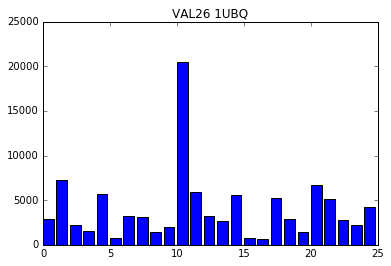

In [139]:
plt.bar(cnts.keys(),cnts.values())
plt.title("VAL26 1UBQ")

Hmm.. although many components are used, there is clearly a dominant component.  Let's look at some of the other models.

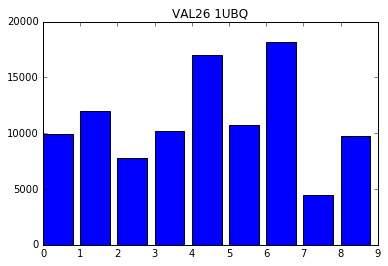

In [137]:
cnts = collections.Counter(gmm9.predict(valshifts))
plt.bar(cnts.keys(),cnts.values())
plt.title("VAL26 1UBQ")

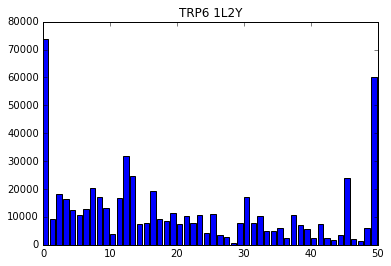

In [140]:
cnts = collections.Counter(gmm.predict(resshifts))
plt.bar(cnts.keys(),cnts.values())
plt.title("TRP6 1L2Y")

In [144]:
cnts[0],cnts[49]
gmm.means_[0],gmm.means_[49]

(array([ 121.29897146,    6.90378029,   62.25615334]),
 array([ 118.44525084,    6.43068192,   60.96934856]))

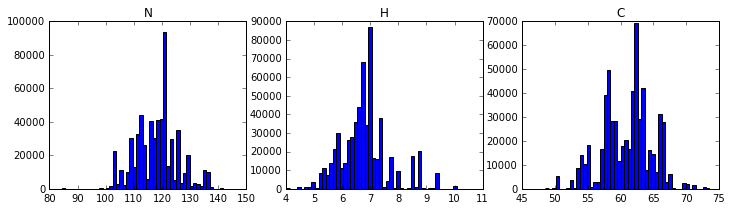

In [148]:
fresshifts

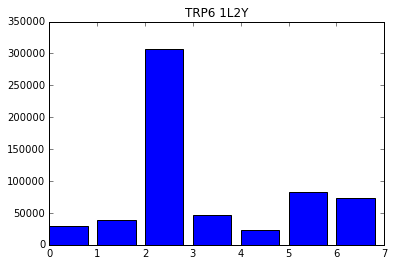

In [153]:
cnts = collections.Counter(gmm7.predict(resshifts))
plt.bar(cnts.keys(),cnts.values())
plt.title('TRP6 1L2Y')

In [154]:
cnts[2],gmm7.means_[2]

(306512, array([ 118.07169731,    6.47843529,   61.62273832]))

## Conclusions

Two residues, TRP6 1L2Y and VAL26 1UBQ, which are presumed to represent opposite extremes in conformational stability were investigated to see if their chemical shifts can be readily fit using Gaussian mixture models.

* Surprisingly (to me), it was **not** possible to achieve good fits using a small number of Gaussians
    * Continous (if not monotonic) improvement in BIC (Baysian information content) was observed out to 50 components
* The components are not uniformly distributed - one or two stand out as predominant
    * more investigation is needed to verify this trend
    * the predominant Gaussians still aren't in the majority
    * different numbers of components yield different patterns
    * this dominant Gaussian appears to be one that's located around the overall mean